<a href="https://colab.research.google.com/github/NoomyWasTaken/computer_vision_project/blob/main/RestorationGANs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install kaggle

In [ ]:
############### THIS
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# copy kaggle.json to /root/.kaggle/ folder so that kaggle cli can access it.
!mkdir /.kaggle
!cp /content/drive/MyDrive/kaggle.json /.kaggle
!mv /.kaggle /root/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d arnaud58/flickrfaceshq-dataset-ffhq

100% 19.5G/19.5G [14:22<00:00, 25.3MB/s]
100% 19.5G/19.5G [14:22<00:00, 24.2MB/s]


In [ ]:
!cp /content/flickrfaceshq-dataset-ffhq.zip /content/drive/MyDrive

In [ ]:
# !unzip "/content/drive/MyDrive/Dataset.zip" #Dataset.zip for chirss

unzip:  cannot find or open /content/drive/MyDrive/Dataset.zip, /content/drive/MyDrive/Dataset.zip.zip or /content/drive/MyDrive/Dataset.zip.ZIP.


In [ ]:
############### THIS
#import part
import torch
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import Dataset, DataLoader
from skimage.color import rgb2lab, lab2rgb
import torch.optim as optim
import os
from torchvision.datasets import CIFAR10
from torch.utils.tensorboard import SummaryWriter  # For logging, similar to checkpointing
from PIL import Image
import zipfile
import cv2
import random

IMAGE_SIZE = 32

In [ ]:
############### THIS
WORKDIR = "/content/sample_data"

### **DATA PART**

In [ ]:
############### THIS
# Extract the dataset zip file - adjust 'path_to_zip_file' and 'extraction_path' as needed
# zip_path = 'flickrfaceshq-dataset-ffhq.zip'  # Adjust this to the path of your downloaded zip file
zip_path = '/content/drive/MyDrive/flickrfaceshq-dataset-ffhq.zip'
extraction_path = '/content/ffhq'  # Adjust or set where you want to extract the images

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extraction_path)


FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/flickrfaceshq-dataset-ffhq.zip'

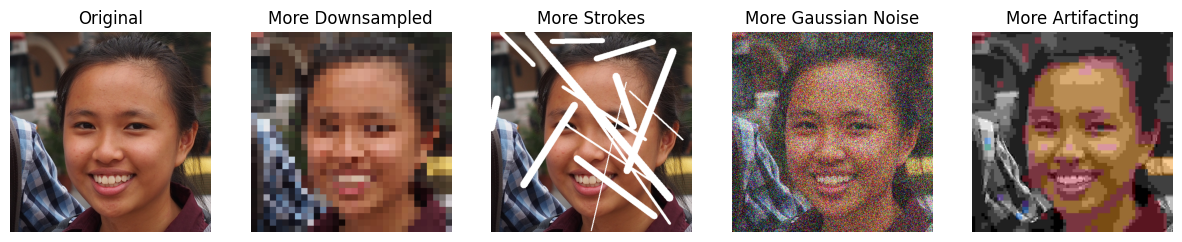

In [ ]:
############### THIS
extraction_path = '/content/ffhq'
## Assuming you have a way to select a single image, e.g., the first image in the directory
image_files = os.listdir(extraction_path)
image_path = os.path.join(extraction_path, image_files[0])  # Adjust based on how you want to select the image
# image_path = '/content/ffhq/original/00140.png'
image = Image.open(image_path)

#3 Convert to numpy array for manipulation
image_np = np.array(image)

#3 Apply different types of noise

## Add random strokes
def add_strokes(image, num_strokes=5):
    for _ in range(num_strokes):
        start_point = (random.randint(0, image.shape[1]), random.randint(0, image.shape[0]))
        end_point = (random.randint(0, image.shape[1]), random.randint(0, image.shape[0]))
        thickness = random.randint(1, 20)
        # color = (random.randint(0, 255), random.randint(0, 255), random.randint(0, 255))
        color = (255, 255, 255) #RGB value for white
        cv2.line(image, start_point, end_point, color, thickness)
    return image

## Increase downsampling by reducing to a smaller size
def apply_downsampling(image_np, downscale_factor=32, original_size=(512, 512)):
    # Downsample and then upsample to introduce pixelation
    downsampled = cv2.resize(image_np, (downscale_factor, downscale_factor), interpolation=cv2.INTER_LINEAR)
    return cv2.resize(downsampled, original_size, interpolation=cv2.INTER_NEAREST)

## Adding more Gaussian Noise
def add_gaussian_noise(image_np, variance=10000):
    mean = 0
    sigma = variance ** 0.5
    gaussian = np.random.normal(mean, sigma, image_np.shape)
    noisy_image = np.clip(image_np + gaussian, 0, 255).astype(np.uint8)
    return noisy_image

## More Artifacting - Decrease JPEG quality further
def add_compression_artifacts(image_np, quality=1):
    encode_param = [int(cv2.IMWRITE_JPEG_QUALITY), quality]
    _, encoded_img = cv2.imencode('.jpg', image_np, encode_param)
    decoded_img = cv2.imdecode(encoded_img, 1)
    return decoded_img


## Demonstrating functions on 1 image
stroke = image_np.copy()
stroke = add_strokes(stroke, num_strokes=random.randint(5, 15))
downsampled = image_np.copy()
downsampled = apply_downsampling(downsampled)
gaussian_noise = image_np.copy()
gaussian_noise = add_gaussian_noise(gaussian_noise)
artifacted = image_np.copy()
artifacted = add_compression_artifacts(artifacted)


## Display the images
fig, ax = plt.subplots(1, 5, figsize=(15, 3))
ax[0].imshow(image_np)
ax[0].set_title('Original')
ax[1].imshow(downsampled)
ax[1].set_title('More Downsampled')
ax[2].imshow(stroke)
ax[2].set_title('More Strokes')
ax[3].imshow(gaussian_noise)
ax[3].set_title('More Gaussian Noise')
ax[4].imshow(artifacted)
ax[4].set_title('More Artifacting')
for a in ax:
    a.axis('off')
plt.show()

In [ ]:
############### THIS
# Create Folders for Augmented Images
augmentation_types = ['original', 'downsampled', 'strokes', 'gaussian_noise', 'artifacted']
for aug_type in augmentation_types:
    os.makedirs(os.path.join(extraction_path, aug_type), exist_ok=True)

In [ ]:
############### THIS
for i, file_name in enumerate(image_files[:1000]):
    if not file_name.lower().endswith(('.png', '.jpg', '.jpeg')):  # Skip non-image files
        continue

    image_path = os.path.join(extraction_path, file_name)
    image = Image.open(image_path)
    image_np = np.array(image)

    # Original
    Image.fromarray(image_np).save(os.path.join(extraction_path, 'original', file_name))

    # Apply and save each augmentation
    aug_functions = {
        'downsampled': apply_downsampling,
        'strokes': lambda img: add_strokes(img, num_strokes=random.randint(5, 15)),
        'gaussian_noise': add_gaussian_noise,
        'artifacted': add_compression_artifacts,
    }
    for aug_name, aug_func in aug_functions.items():
        augmented_image_np = image_np.copy()  # Start with a fresh copy for each augmentation
        augmented_image = aug_func(augmented_image_np)  # Apply augmentation
        Image.fromarray(augmented_image).save(os.path.join(extraction_path, aug_name, file_name))  # Save augmented image

    if i % 100 == 0:
        print(f"Processed {i} images...")

print("Done processing 1000 images.")

Processed 0 images...
Processed 100 images...
Processed 200 images...
Processed 300 images...
Processed 400 images...
Processed 500 images...
Processed 600 images...
Processed 700 images...
Processed 800 images...
Processed 900 images...
Done processing 1000 images.


In [ ]:
# Copy from here to Drive
destination_root = '/content/drive/MyDrive/GANs_Restoration_Images'
augmentation_types = ['original', 'downsampled', 'strokes', 'gaussian_noise', 'artifacted']

for aug_type in augmentation_types:
    source_folder = os.path.join(extraction_path, aug_type)
    destination_folder = os.path.join(destination_root, aug_type)
    !cp -r "{source_folder}" "{destination_folder}"
    print(f"Copied {aug_type} to Google Drive.")

Copied original to Google Drive.
Copied downsampled to Google Drive.
Copied strokes to Google Drive.
Copied gaussian_noise to Google Drive.
Copied artifacted to Google Drive.


In [ ]:
# Copy from Drive to here
drive_path = '/content/drive/MyDrive/GANs_Restoration_Images'
destination_root = '/content/ffhq'
augmentation_types = ['original', 'downsampled', 'strokes', 'gaussian_noise', 'artifacted']

for aug_type in augmentation_types:
    source_folder = os.path.join(drive_path, aug_type)
    destination_folder = os.path.join(destination_root, aug_type)
    !cp -r "{source_folder}" "{destination_folder}"
    print(f"Copied {aug_type} to Google Drive.")

Copied original to Google Drive.
Copied downsampled to Google Drive.
Copied strokes to Google Drive.
Copied gaussian_noise to Google Drive.
Copied artifacted to Google Drive.


In [ ]:
############### THIS
class MixedNoiseDataset(Dataset):
    def __init__(self, clean_dir, noisy_dirs, transform=None):
        """
        Args:
            clean_dir (string): Directory with all the clean images.
            noisy_dirs (list): List of directories with the noisy images.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.clean_dir = clean_dir
        self.noisy_dirs = noisy_dirs
        self.transform = transform
        self.images = os.listdir(clean_dir)
        self.noisy_images = []
        for noisy_dir in noisy_dirs:
            for img_name in os.listdir(noisy_dir):
                self.noisy_images.append((img_name, noisy_dir))

    def __len__(self):
        return len(self.noisy_images)

    def __getitem__(self, idx):
        img_name, noisy_dir = self.noisy_images[idx]
        clean_img_path = os.path.join(self.clean_dir, img_name)
        noisy_img_path = os.path.join(noisy_dir, img_name)

        clean_img = Image.open(clean_img_path).convert('RGB')
        noisy_img = Image.open(noisy_img_path).convert('RGB')

        if self.transform:
            clean_img = self.transform(clean_img)
            noisy_img = self.transform(noisy_img)

        return noisy_img, clean_img

In [ ]:
############### THIS
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((512, 512)), # Resize if necessary. Adjust to match your GAN input size.
])

clean_dir = '/content/ffhq/original'
noisy_dirs = [
    '/content/ffhq/artifacted',
    '/content/ffhq/downsampled',
    '/content/ffhq/gaussian_noise',
    '/content/ffhq/strokes'
]

dataset = MixedNoiseDataset(clean_dir=clean_dir, noisy_dirs=noisy_dirs, transform=transform)

dataloader = DataLoader(dataset, batch_size=8, shuffle=True, num_workers=2)

In [ ]:
# #data part

# # Path to your dataset
# dataset_path = '/content/DIV2K_train_HR'

# # List all files in the directory
# image_files = [os.path.join(dataset_path, f) for f in os.listdir(dataset_path) if os.path.isfile(os.path.join(dataset_path, f))]

# # Load images
# images = [Image.open(f) for f in image_files]

# # Now `images` is a list of PIL Image objects

In [ ]:
# from torchvision.transforms import Resize
# from torchvision.transforms.functional import to_pil_image, to_tensor


# # Updated transformation for DIV2K dataset including resizing to 32x32
# div2k_transform = transforms.Compose([
#     Resize((128, 128)),  # Resize the image to 32x32 pixels #can't resize here
#     transforms.ToTensor(),
#     transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
# ])

# class DIV2KLabDataset(Dataset):
#     def __init__(self, root, transform=None):
#         # It's crucial to apply the transformation when loading the images to ensure they're resized
#         self.dataset = ImageFolder(root=root, transform=transform)
#         self.transform = transform

#     def __len__(self):
#         return len(self.dataset)

#     # def __getitem__(self, idx):
#     #     image, _ = self.dataset[idx]  # Extracts the image already resized and transformed

#     #     # Convert transformed image to numpy array
#     #     image_np = np.array(image.permute(1, 2, 0))  # Adjust for the shape (H, W, C) expected by rgb2lab

#     #     # Convert RGB to Lab
#     #     lab_image_array = rgb2lab(image_np)
#     #     x = lab_image_array[:, :, 0]
#     #     y = lab_image_array[:, :, 1:]

#     #     # Normalize LAB channels
#     #     x = (x / 50) - 1  # Normalize L channel between -1 and 1
#     #     y /= 128  # Normalize ab channels between -1 and 1

#     #     # Convert to PyTorch tensors
#     #     x_tensor = torch.from_numpy(x).unsqueeze(0).float()  # Add channel dimension
#     #     y_tensor = torch.from_numpy(y.transpose(2, 0, 1)).float()  # Change HxWxC to CxHxW for PyTorch

#     #     return x_tensor, y_tensor

#     def __getitem__(self, idx):
#       #image, _ = self.dataset[idx]  # Extracts the image already resized and transformed
#       original_image_tensor, _ = self.dataset[idx]  # Extracts the original transformed tensor and ignores the label

#       # Convert the PyTorch tensor to a PIL Image for easy manipulation
#       #image_pil = to_pil_image(image)
#       image_pil = to_pil_image(original_image_tensor)

#       # Decrease resolution then increase it
#       low_res_size = (32, 32)
#       high_res_size = (128, 128)  # Explicitly set this to ensure clarity
#       image_low_res = image_pil.resize(low_res_size, Image.BICUBIC)
#       #image_low_high_res = image_low_res.resize(high_res_size, Image.BICUBIC)

#       # Convert back to tensor
#       low_high_res_tensor = to_tensor(image_low_res)

#       # Normalize (using your chosen normalization parameters)
#       transform_norm = transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
#       low_high_res_tensor_norm = transform_norm(low_high_res_tensor)

#       return low_high_res_tensor_norm, original_image_tensor



#     def create_dataloaders(batch_size, shuffle=True):
#         train_dataset = DIV2KLabDataset(root='/content/DIV2K_train_HR', transform=div2k_transform)
#         #test_dataset = DIV2KLabDataset(root='/content/DIV2K_train_HR', train=False, transform=div2k_transform, download=True)

#         train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=shuffle)
#         #test_loader = DataLoader(test_dataset, batch_size=batch_size)

#         #return train_loader, test_loader
#         return train_loader

# # Example usage
# batch_size = 64
# #train_loader, test_loader = create_dataloaders(batch_size)
# train_loader = create_dataloaders(batch_size)


# #print the shape of the image
# images,  target= next(iter(train_loader))
# #print(images.shape)  # Expecting torch.Size([batch_size, channels, height, width])
# #rint(target.shape)


NameError: name 'create_dataloaders' is not defined

# **Model Part**

**Generator Model in PyTorch**

In [ ]:
############### THIS
# Initialize weights
def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
    elif isinstance(m, nn.BatchNorm2d):
        torch.nn.init.normal_(m.weight, 1.0, 0.02)
        torch.nn.init.constant_(m.bias, 0)

# Downsample
class Downsample(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, apply_batchnorm=True):
        super(Downsample, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride=2, padding=1, bias=False)
        self.batchnorm = nn.BatchNorm2d(out_channels) if apply_batchnorm else None
        self.leakyrelu = nn.LeakyReLU(0.2)

    def forward(self, x):
        x = self.conv(x)
        if self.batchnorm is not None:
            x = self.batchnorm(x)
        x = self.leakyrelu(x)
        return x

# Upsample
class Upsample(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, apply_dropout=False):
        super(Upsample, self).__init__()
        self.deconv = nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride=2, padding=1, bias=False)
        self.batchnorm = nn.BatchNorm2d(out_channels)
        self.dropout = nn.Dropout(0.5) if apply_dropout else None
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.deconv(x)
        x = self.batchnorm(x)
        if self.dropout is not None:
            x = self.dropout(x)
        x = self.relu(x)
        return x

class AutoencoderGenerator1(nn.Module):
    def __init__(self):
        super(AutoencoderGenerator1, self).__init__()
        self.downstack = nn.ModuleList([
            Downsample(3, 32, 4, apply_batchnorm=True),
            Downsample(32, 64, 4),
            Downsample(64, 128, 4),
            Downsample(128, 256, 4),
            Downsample(256, 256, 4),
        ])

        self.upstack = nn.ModuleList([
            Upsample(256, 256, 4, apply_dropout=True),
            Upsample(512, 128, 4),
            Upsample(256, 64, 4),
            Upsample(128, 32, 4),

        ])
        self.Upsample = Upsample(64, 3, 4)
        # self.outconv = nn.ConvTranspose2d(3, 3, 4, stride=1, padding=1, output_padding=0)
        # self.outconv2 = nn.ConvTranspose2d(3, 3, 3, stride=1, padding=1, output_padding=0)
        self.tanh = nn.Tanh()

    def forward(self, x):

        skips = []
        for down in self.downstack:
            x = down(x)
            skips.append(x)
        skips = reversed(skips[:-1])

        for up, skip in zip(self.upstack, skips):

            x = up(x)

            x = torch.cat((x, skip), 1)


        #print(x.shape)

        x = self.Upsample(x)
        # print(x.shape)
        # x = F.interpolate(x, size=(512, 512), mode='bilinear', align_corners=False)
        # x = self.outconv(x)
        # x = self.outconv2(x)
        x = self.tanh(x)

        return x

# Define image size
IMAGE_SIZE = 512  # replace with your value



# Create the model

# Assuming you have an input tensor `input_tensor`
# output = model(input_tensor)

**Discriminator model**

In [ ]:
############### THIS
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 32, 3, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.25),
            nn.Conv2d(32, 64, 3, stride=2, padding=1),
            nn.ZeroPad2d((0, 1, 0, 1)),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.25),
            nn.Conv2d(64, 128, 3, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.25),
            nn.Conv2d(128, 256, 3, stride=1, padding=0),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.25),
            nn.Flatten(),
            nn.Linear(1016064, 1), # 0 for the fake, 1 for the real image
            nn.Sigmoid(),
        )

    def forward(self, img):
        return self.conv_layers(img)

**Loss Function**

In [ ]:
############### THIS
LAMBDA = 10

# Binary Cross Entropy Loss for discriminator
bce_loss = nn.BCEWithLogitsLoss()

def discriminator_loss(disc_real_output, disc_generated_output):
    # All-real batch should be classified as 1s, hence we create a tensor of ones with the same shape as disc_real_output
    #print(disc_real_output, disc_generated_output)
    real_loss = bce_loss(disc_real_output, torch.ones_like(disc_real_output))
    # All-fake batch should be classified as 0s, hence we create a tensor of zeros with the same shape as disc_generated_output
    generated_loss = bce_loss(disc_generated_output, torch.zeros_like(disc_generated_output))
    # Total discriminator loss is the sum of real and generated losses
    total_disc_loss = real_loss + generated_loss
    return total_disc_loss

def generator_loss(disc_generated_output, gen_output, target):
    # Generator wants disc_generated_output to look like real, so we compare against a tensor of ones
    gan_loss = bce_loss(disc_generated_output, torch.ones_like(disc_generated_output))
    # L1 loss between generated image and the target
    l1_loss = torch.mean(torch.abs(target - gen_output))
    # Total generator loss is GAN loss + LAMBDA times the L1 loss
    total_gen_loss = gan_loss + (LAMBDA * l1_loss)
    return total_gen_loss, gan_loss, l1_loss


**Model initialization and optimizer setup**

In [ ]:
############### THIS
# Assuming AutoencoderGenerator and Discriminator are the PyTorch classes we defined earlier
#generator = AutoencoderGenerator(image_size=IMAGE_SIZE)
#generator = Generator(image_size=IMAGE_SIZE)
generator = AutoencoderGenerator1()
discriminator = Discriminator()

# Initialize optimizers
generator_optimizer = optim.Adam(generator.parameters(), lr=2e-4, betas=(0.5, 0.999))
discriminator_optimizer = optim.Adam(discriminator.parameters(), lr=2e-4, betas=(0.5, 0.999))

# Set up checkpoint directory
checkpoint_dir = os.path.join(WORKDIR, 'training-checkpoints')
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
if not os.path.exists(checkpoint_prefix):
    os.makedirs(checkpoint_prefix)
drive_path = "/content/drive/MyDrive/GANs_Restoration_Images"

# TensorBoard writer setup for PyTorch, which can also be used to save checkpoints
writer = SummaryWriter(checkpoint_dir)

# Save and Load Functions
def save_checkpoint(epoch):
    torch.save({
        'epoch': epoch,
        'generator_state_dict': generator.state_dict(),
        'discriminator_state_dict': discriminator.state_dict(),
        'generator_optimizer_state_dict': generator_optimizer.state_dict(),
        'discriminator_optimizer_state_dict': discriminator_optimizer.state_dict(),
    }, os.path.join(checkpoint_prefix, f"epoch_{epoch}.pth"))
    torch.save({
        'epoch': epoch,
        'generator_state_dict': generator.state_dict(),
        'discriminator_state_dict': discriminator.state_dict(),
        'generator_optimizer_state_dict': generator_optimizer.state_dict(),
        'discriminator_optimizer_state_dict': discriminator_optimizer.state_dict(),
    }, os.path.join(drive_path, f"epoch_{epoch}.pth"))

def load_checkpoint(epoch, device):
    checkpoint = torch.load(os.path.join(checkpoint_prefix, f"epoch_{epoch}.pth"), map_location=device)
    generator.load_state_dict(checkpoint['generator_state_dict'])
    discriminator.load_state_dict(checkpoint['discriminator_state_dict'])
    generator_optimizer.load_state_dict(checkpoint['generator_optimizer_state_dict'])
    discriminator_optimizer.load_state_dict(checkpoint['discriminator_optimizer_state_dict'])
    return checkpoint['epoch']


# **Training part**

In [ ]:
# # **Training Part**

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# def train(num_epochs):
#     generator.to(device)
#     discriminator.to(device)

#     generator.train()
#     discriminator.train()
#     for epoch in range(num_epochs):
#         for i, (X, Y) in enumerate(train_loader):
#             X = X.to(device)
#             Y = Y.to(device)
#             # Train Discriminator
#             discriminator_optimizer.zero_grad()
#             #print(X.shape)
#             #print(Y.shape)


#             fake_images = generator(X).detach()
#             #real_images = torch.cat((X,Y), 1)
#             real_images = Y.to(device)
#             #fake_images = torch.cat((X,fake_images), 1)
#             fake_images = fake_images.to(device)

#             real_pred = discriminator(real_images)
#             fake_pred = discriminator(fake_images)

#             d_loss = discriminator_loss(real_pred, fake_pred)
#             d_loss.backward()
#             discriminator_optimizer.step()

#             # Train Generator

#             fake_images = generator(X)
#             #fake_images = torch.cat((X,fake_images), 1) #brings it together and we do not need iot
#             generator_optimizer.zero_grad()
#             fake_images = fake_images.to(device)
#             fake_pred = discriminator(fake_images)
#             g_loss, gan_loss, l1_loss = generator_loss(fake_pred, fake_images, real_images)
#             g_loss.backward()
#             generator_optimizer.step()

#             # if i % 100 == 0:
#             #     print(
#             #         f"Epoch [{epoch}/{num_epochs}], Step [{i}/{len(train_loader)}], "
#             #         f"Discriminator Loss: {d_loss.item():.4f}"
#             #     )
#             # Print losses
#             if i % 100 == 0:
#                 print(
#                     f"Epoch [{epoch}/{num_epochs}], Step [{i}/{len(train_loader)}], "
#                     f"Generator Loss: {g_loss.item():.4f}, Discriminator Loss: {d_loss.item():.4f}"
#                 )

#         # Save checkpoint
#         save_checkpoint(epoch)

# # Start training
# num_epochs = 10
# train(num_epochs)


Epoch [0/150], Step [0/13], Generator Loss: 5.3272, Discriminator Loss: 1.0083
Epoch [1/150], Step [0/13], Generator Loss: 5.0057, Discriminator Loss: 1.0075
Epoch [2/150], Step [0/13], Generator Loss: 5.0881, Discriminator Loss: 1.0070
Epoch [3/150], Step [0/13], Generator Loss: 5.0771, Discriminator Loss: 1.0069
Epoch [4/150], Step [0/13], Generator Loss: 4.6605, Discriminator Loss: 1.0069
Epoch [5/150], Step [0/13], Generator Loss: 4.5794, Discriminator Loss: 1.0069
Epoch [6/150], Step [0/13], Generator Loss: 4.5221, Discriminator Loss: 1.0068
Epoch [7/150], Step [0/13], Generator Loss: 4.3877, Discriminator Loss: 1.0069
Epoch [8/150], Step [0/13], Generator Loss: 4.2702, Discriminator Loss: 1.0068
Epoch [9/150], Step [0/13], Generator Loss: 4.0860, Discriminator Loss: 1.0068
Epoch [10/150], Step [0/13], Generator Loss: 4.1629, Discriminator Loss: 1.0068
Epoch [11/150], Step [0/13], Generator Loss: 3.8849, Discriminator Loss: 1.0066
Epoch [12/150], Step [0/13], Generator Loss: 3.773

RuntimeError: Parent directory /content/sample_data/training-checkpoints/ckpt does not exist.

In [ ]:
############### THIS
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
load_epoch = 0
load_checkpoint(load_epoch)
def train(dataloader, generator, discriminator, g_optimizer, d_optimizer, g_loss_func, d_loss_func, num_epochs):
    generator.to(device)
    discriminator.to(device)

    for epoch in range(load_epoch + 1, num_epochs):
        for i, (noisy_imgs, clean_imgs) in enumerate(dataloader):  # Update variable names
            noisy_imgs = noisy_imgs.to(device)
            clean_imgs = clean_imgs.to(device)
            # print(clean_imgs.shape)

            # Train Discriminator
            d_optimizer.zero_grad()

            fake_images = generator(noisy_imgs).detach()
            # print(fake_images.shape)
            real_pred = discriminator(clean_imgs)
            fake_pred = discriminator(fake_images)
            d_loss = d_loss_func(real_pred, fake_pred)
            d_loss.backward()
            d_optimizer.step()

            # Train Generator
            generator.train()  # In case generator has dropout or batchnorm layers that behave differently during training
            fake_images = generator(noisy_imgs)
            g_optimizer.zero_grad()
            fake_pred = discriminator(fake_images)
            g_loss, gan_loss, l1_loss = g_loss_func(fake_pred, fake_images, clean_imgs)  # Adjusted to unpack the loss if it returns multiple values
            g_loss.backward()
            g_optimizer.step()

            if i % 100 == 0:
                print(f"Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(dataloader)}], "
                      f"Generator Loss: {g_loss.item():.4f}, Discriminator Loss: {d_loss.item():.4f}")

        # Save checkpoint
        save_checkpoint(epoch)  # Assuming save_checkpoint takes epoch, generator, and discriminator as arguments

# Assuming the existence of optimizers and loss functions
train(dataloader, generator, discriminator, generator_optimizer, discriminator_optimizer, generator_loss, discriminator_loss, num_epochs=10)


Epoch [2/10], Step [1/500], Generator Loss: 1.8056, Discriminator Loss: 1.3863
Epoch [2/10], Step [101/500], Generator Loss: 1.5630, Discriminator Loss: 1.3863
Epoch [2/10], Step [201/500], Generator Loss: 1.5932, Discriminator Loss: 1.3863
Epoch [2/10], Step [301/500], Generator Loss: 1.9369, Discriminator Loss: 1.3863
Epoch [2/10], Step [401/500], Generator Loss: 1.8829, Discriminator Loss: 1.3863


KeyboardInterrupt: 

In [ ]:
!cp /content/drive/MyDrive/GANs_Restoration_Images/epoch_9.pth /content/sample_data/training-checkpoints/ckpt

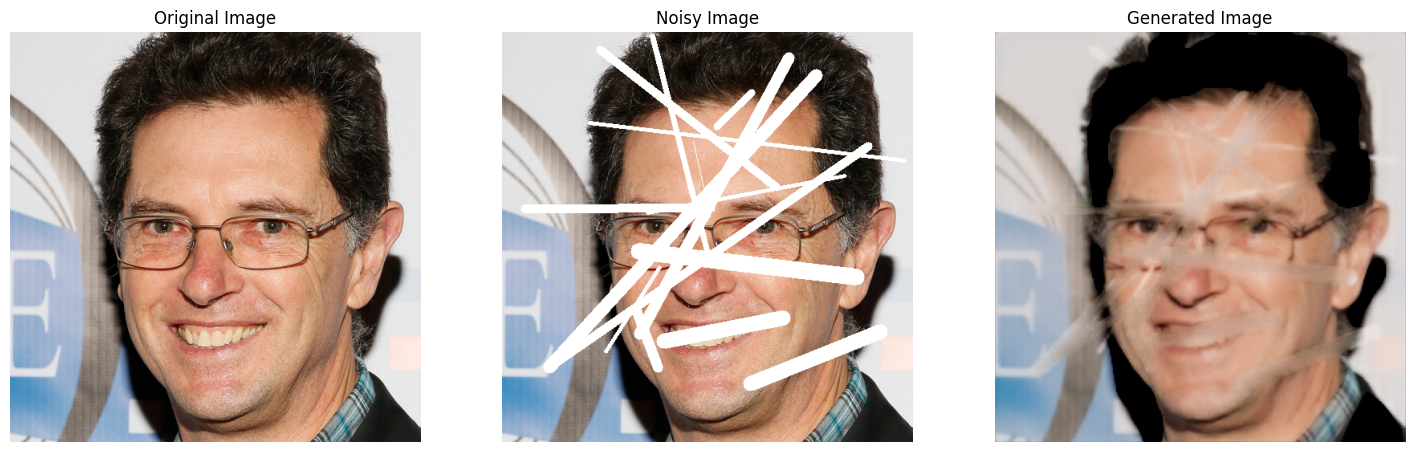

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
load_epoch = 9
load_checkpoint(load_epoch, device)
# Assuming you have a train_loader defined and loaded with your dataset
def test_model(dataloader):
    generator.eval()  # Set the generator to evaluation mode

    with torch.no_grad():  # Ensure gradients are not calculated
        for i, (X, Y) in enumerate(dataloader):
            if i == 0:  # Only use the first batch from the train loader
                X = X.to(device)

                # Generate fake images
                fake_images = generator(X)

                # Display the original, noisy, and generated images side by side
                plt.figure(figsize=(18, 6))
                plt.subplot(1, 3, 1)
                plt.imshow(np.transpose(Y[0], (1, 2, 0)))
                plt.title('Original Image')
                plt.axis('off')

                plt.subplot(1, 3, 2)
                plt.imshow(np.transpose(X[0], (1, 2, 0)))
                plt.title('Noisy Image')
                plt.axis('off')

                plt.subplot(1, 3, 3)
                plt.imshow(np.transpose(fake_images[0], (1, 2, 0)))
                plt.title('Generated Image')
                plt.axis('off')

                plt.show()
                break  # Exit after processing the first batch

# Load the appropriate checkpoint before testing
# epoch_to_load = 9  # Specify which epoch's model to load
# load_checkpoint(epoch_to_load)

# Test the model using the train loader
test_model(dataloader)
